# Model Training

## Required Libraries

In [113]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import joblib
%matplotlib inline

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score, jaccard_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay


## Import Dataset

In [3]:
df = pd.read_csv("data\data_cleaned.csv")

In [4]:
df.head(3)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,6,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,0,1,False,False,False,No Pad,1.0,0,B0003,-80.577366,28.561857
1,8,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,0,1,False,False,False,No Pad,1.0,0,B0005,-80.577366,28.561857
2,10,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,0,1,False,False,False,No Pad,1.0,0,B0007,-80.577366,28.561857


In [10]:
df.shape

(168, 17)

## Preparing Indepnedent (X) and Dependent (Y) Features

In [11]:
X = df.drop(['Outcome', 'Date', 'Longitude', 'Latitude'], axis= 1)

target_column_name = 'Outcome'
y = df[target_column_name]

In [21]:
X.shape

(168, 13)

## Feature Engineering

In [19]:
num_columns = ['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount']
cat_columns = ['BoosterVersion', 'Orbit', 'LaunchSite', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Serial']

In [20]:
num_pipeline = Pipeline(
    steps= [
        ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps= [
       ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore')) 
    ]
)

preprocessor = ColumnTransformer(
    transformers= [
        ('num_preprocess', num_pipeline, num_columns),
        ('cat_preprocess', cat_pipeline, cat_columns)
    ]
)

In [22]:
X = preprocessor.fit_transform(X)
X.shape

(168, 96)

## Train Test Split

In [24]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= .2, random_state= 42)

## Evaluation Matrix

In [28]:
def evaluate_model(true, predicted, predicted_proba= None):
    acc = accuracy_score(true, predicted)
    jac = jaccard_score(true, predicted)
    prec = precision_score(true, predicted, average='weighted', zero_division=0)
    rec = recall_score(true, predicted, average='weighted')
    f1 = f1_score(true, predicted, average='weighted')

    metrics = {
        'Accuracy': acc,
        'Jaccard': jac,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

    if predicted_proba is not None and len(np.unique(true)) == 2:
        auc = roc_auc_score(true, predicted_proba[:, 1])
        metrics['ROC AUC'] = auc

    return metrics


## Models and Hyperparameters

In [30]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=0)
}

params = {
    'Logistic Regression': {
        'C': np.logspace(-3, 2, 6)
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10, None]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'subsample': [0.7, 0.85, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'depth': [3, 5, 7]
    }
}

## GridSearchCV

In [32]:
report = []
best_model = None
best_score = - np.inf

for model_name, model in models.items():
    grid = GridSearchCV(
        estimator= model,
        param_grid= params[model_name],
        cv= 10,
        scoring= 'accuracy',
        error_score= 'raise'
    )

    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_param = grid.best_params_

    y_pred_train = best_estimator.predict(X_train)
    y_pred_test = best_estimator.predict(X_test)
    y_proba_test = best_estimator.predict_proba(X_test) if hasattr(best_estimator, 'predict_proba') else None

    metrics_train = evaluate_model(y_train, y_pred_train)
    metrics_test = evaluate_model(y_test, y_pred_test, y_proba_test)

    report.append({
        'Model': model_name,
        'Best Params': best_param,
        'Train Accuracy': metrics_train['Accuracy'],
        'Test Accuracy': metrics_test['Accuracy'],
        'Test Jaccard': metrics_test['Jaccard'],
        'Test Precision': metrics_test['Precision'],
        'Test Recall': metrics_test['Recall'],
        'Test F1': metrics_test['F1 Score'],
        'Test ROC AUC': metrics_test.get('ROC AUC', None)
    })

    if metrics_test['Accuracy'] > best_score:
        best_model = best_estimator
        best_score = metrics_test['Accuracy']

c:\Users\HP\Documents\Projects\Landing_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:23:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\Documents\Projects\Landing_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:23:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\Documents\Projects\Landing_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:23:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\Documents\Projects\Landing_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:23:14] WARNING: C:\actio

In [33]:
report_df = pd.DataFrame(report).sort_values(by='Test Accuracy', ascending=False)
report_df

,Model,Best Params,Train Accuracy,Test Accuracy,Test Jaccard,Test Precision,Test Recall,Test F1,Test ROC AUC
2,KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",0.925373,0.852941,0.833333,0.877451,0.852941,0.831345,0.833333
0,Logistic Regression,{'C': 1.0},0.962687,0.823529,0.800000,0.820284,0.823529,0.804855,0.911111
1,Decision Tree,"{'criterion': 'entropy', 'max_depth': 5}",0.977612,0.823529,0.793103,0.815437,0.823529,0.815894,0.871111
4,AdaBoost,"{'learning_rate': 0.01, 'n_estimators': 50}",0.940299,0.823529,0.800000,0.820284,0.823529,0.804855,0.895556
5,Gradient Boosting,"{'learning_rate': 0.01, 'n_estimators': 100, '...",0.955224,0.823529,0.800000,0.820284,0.823529,0.804855,0.891111
8,CatBoost,"{'depth': 7, 'iterations': 100, 'learning_rate...",1.000000,0.823529,0.785714,0.823529,0.823529,0.823529,0.920000
7,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.940299,0.823529,0.800000,0.820284,0.823529,0.804855,0.931111
3,Random Forest,"{'max_depth': 5, 'n_estimators': 100}",0.962687,0.794118,0.766667,0.780462,0.794118,0.779356,0.915556
6,SVM,"{'C': 10, 'kernel': 'rbf'}",1.000000,0.794118,0.766667,0.780462,0.794118,0.779356,0.871111


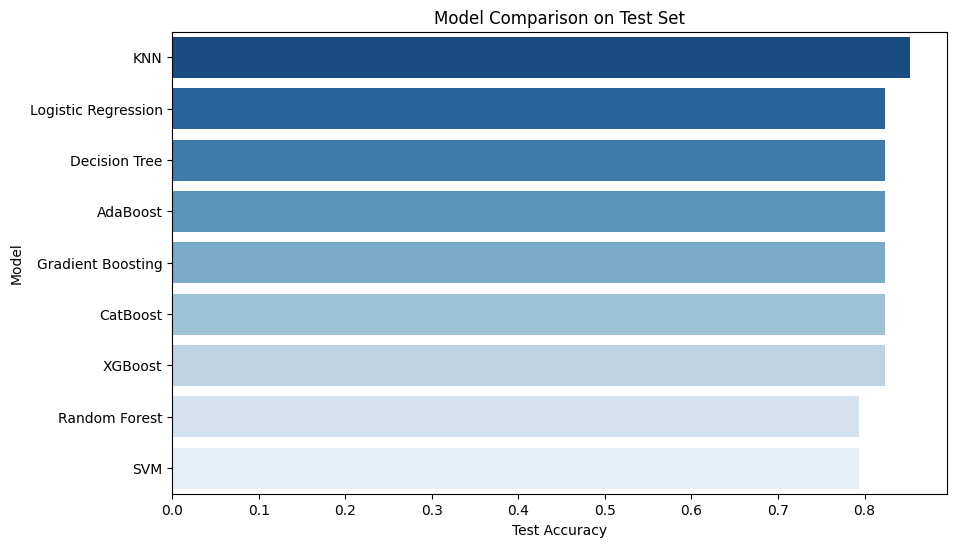

In [123]:
plt.figure(figsize=(10,6))
sns.barplot(x="Test Accuracy", y="Model", data=report_df, hue= "Model", palette="Blues_r")
plt.title("Model Comparison on Test Set")
plt.show()


In [34]:
print(f"Best model is {best_model} with Accuracy (test): {best_score * 100:.2f}%")

Best model is KNeighborsClassifier() with Accuracy (test): 85.29%


## Save the Preprocessor and the Best Model

In [112]:
os.makedirs('models', exist_ok= True)

preprocessor_path = 'models/preprocessor_' + str(datetime.date.today()) + '.pkl'
joblib.dump(preprocessor, preprocessor_path)

best_model_path = 'models/best_model_' + str(datetime.date.today()) + '.pkl'
joblib.dump(best_model, best_model_path)

['models/best_model_2025-09-17.pkl']

## Confusion Matrix

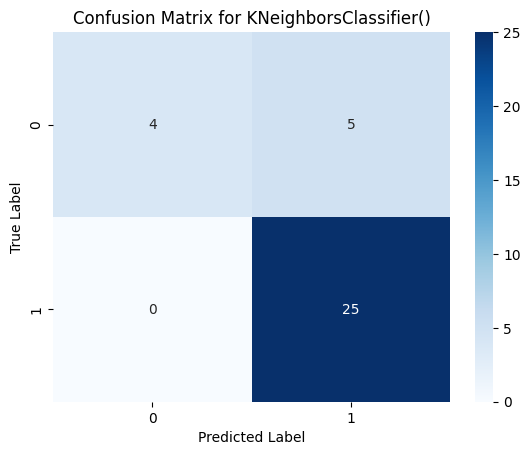

In [46]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True, cmap='Blues')
plt.title(f'Confusion Matrix for {best_model}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## ROC Curve

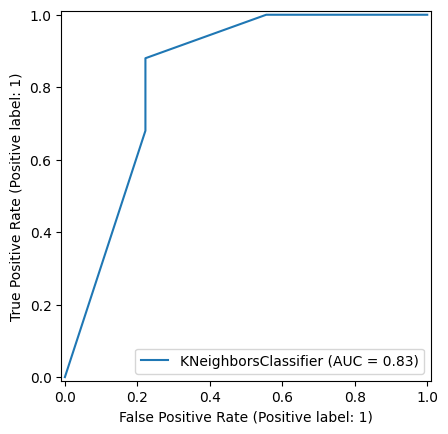

In [48]:
if hasattr(best_model, 'predict_proba') and len(np.unique(y)) == 2:
    RocCurveDisplay.from_estimator(best_model, X_test, y_test)
    plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.83      1.00      0.91        25

    accuracy                           0.85        34
   macro avg       0.92      0.72      0.76        34
weighted avg       0.88      0.85      0.83        34

